In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functions import *

# 1. Data exploration

## 1.1. Preliminary data exploration

As a first step, we import our dataset.

In [2]:
diam_data = pd.read_csv('diamonds.csv', index_col = 0)
diam_data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [3]:
diam_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53940 entries, 1 to 53940
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


In [4]:
diam_data.shape

(53940, 10)

This dataset contains data on 53,940 diamonds, with the following dimensions:
- carat: weight of the diamond (0.2--5.01)
- cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- color: diamond colour, from J (worst) to D (best)
- clarity: measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
- depth: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43-79)
- table: width of top of diamond relative to widest point (43-95)
- price: price of the diamond in USD (\\$326-\\$18,823)
- x, y, z: length, width, depth in mm

Our objective would be to estimate the price of a given diamond, based on its characteristics.

## 1.2. Data visualization

We can start by visualizing the distribution of the variables.

In [5]:
cols_init = diam_data.columns
nrow, ncol = get_n_rowcol(cols_init)

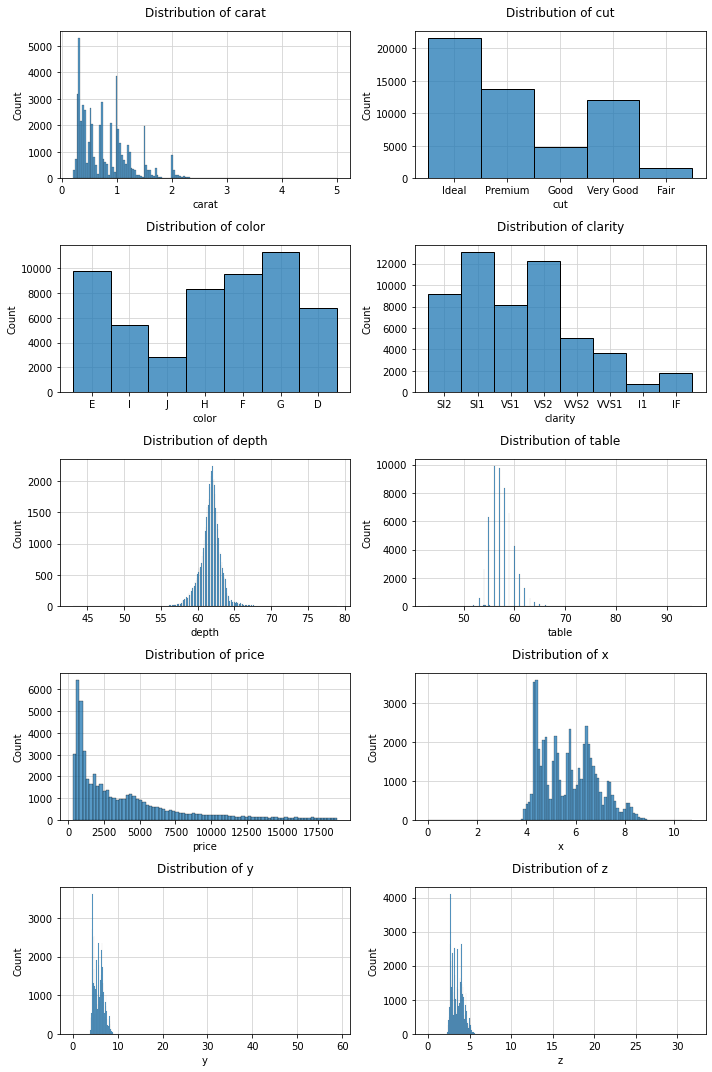

In [6]:
fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*5, nrow*3))

for ax, dim in zip(fig.axes, diam_data.columns):
    sns.histplot(
        x=diam_data[dim],
        ax=ax
    )
    ax.set_title(f"Distribution of {dim}", pad=15)
    ax.grid(True, color="lightgrey")
    ax.set_axisbelow(True)
    
fig.set_tight_layout(True)
    
plt.show()

## 1.3. Preliminary data transformation

We can also plot the diamond price in light of the weight in carats, to see whether there is a clear link, as can be expected.

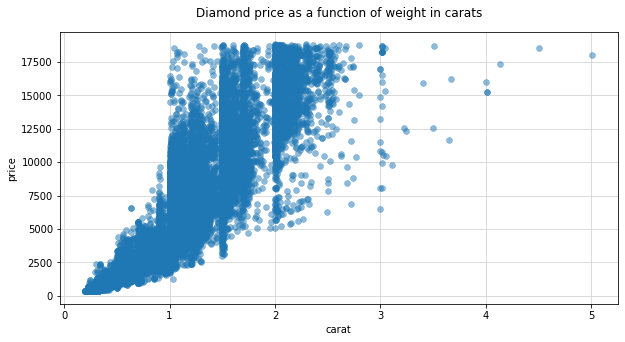

In [7]:
fig, ax = plt.subplots(figsize = (10,5))

sns.scatterplot(
    x=diam_data['carat'],
    y=diam_data['price'],
    ax=ax,
    alpha=0.5,
    edgecolor=None
)

ax.grid(True, color="lightgrey")
ax.set_axisbelow(True)

ax.set_title('Diamond price as a function of weight in carats', pad=15)

plt.show()

One can observe a clear correlation between price and weight, especially for smaller diamonds. Unexpected steps can also be seen, likely related to rounded values when reporting weight in carats, particularly visible for 1, 1.5, and 2 carats.

As such, we will consider a discretization for the weights.

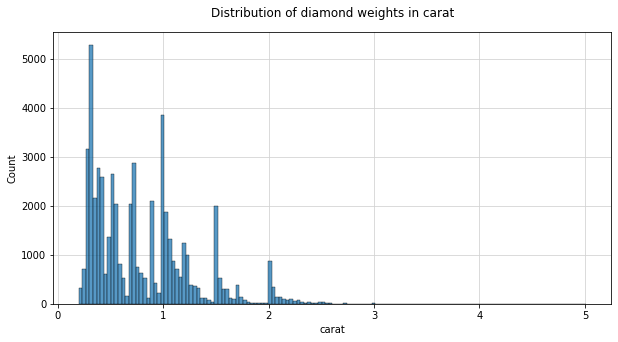

In [8]:
fig, ax = plt.subplots(figsize = (10,5))

sns.histplot(
    x=diam_data['carat'],
    ax=ax
)

ax.set_title('Distribution of diamond weights in carat', pad=15)
ax.grid(True, color="lightgrey")
ax.set_axisbelow(True)

plt.show()

We suggest the following steps: 0-.50, .50-.75, .75-1, 1-1.5, 1.5-2, >2

In [9]:
diam_data['carat_bin'] = pd.cut(
    diam_data['carat'],
    bins=[0, .5, .75, 1, 1.5, 2, +np.inf]
)

We visualize the distribution of this variable.

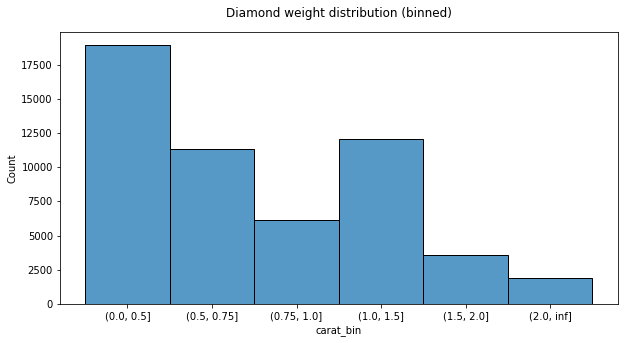

In [10]:
fig, ax = plt.subplots(figsize = (10,5))

sns.histplot(
    x=diam_data['carat_bin'].astype('str'),
    ax=ax
)

ax.set_title('Diamond weight distribution (binned)', pad=15)

plt.show()

In order to limit dependency on weight, we will add a price_p_carat dimension to our database.

In [11]:
diam_data['price_p_carat'] = np.divide(diam_data['price'], diam_data['carat'])

We can then visualize its distribution.

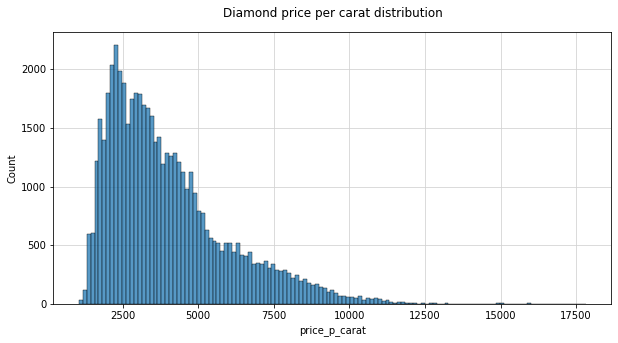

In [12]:
fig, ax = plt.subplots(figsize = (10,5))

sns.histplot(
    x=diam_data['price_p_carat'],
    ax=ax
)

ax.set_title('Diamond price per carat distribution', pad=15)
ax.grid(True, color="lightgrey")
ax.set_axisbelow(True)

plt.show()

Given the shape of the distribution, we will consider a log-transformation, to better disperse the values, maximizing variance.

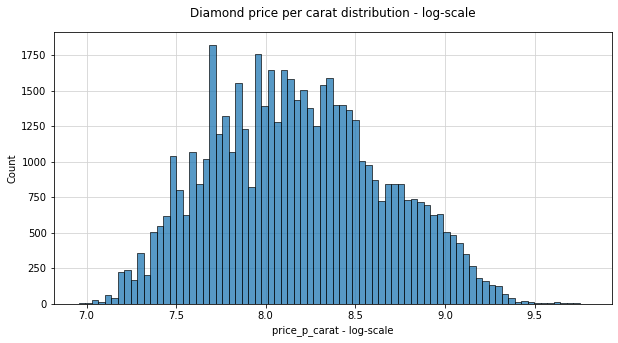

In [13]:
fig, ax = plt.subplots(figsize = (10,5))

sns.histplot(
    x=np.log(diam_data['price_p_carat']),
    ax=ax
)

ax.set_title('Diamond price per carat distribution - log-scale', pad=15)
ax.set_xlabel('price_p_carat - log-scale')
ax.grid(True, color="lightgrey")
ax.set_axisbelow(True)

plt.show()

We then add this log-transformed variable to our dataset.

In [14]:
diam_data['price_p_carat_log'] = np.log(diam_data['price_p_carat'])

## 1.4. Data imputation

While at first glance there are no missing values in our dataset, looking at it more closely shows that a few values have been set to 0.

In [15]:
for col in cols_init:
    print(f"- {col}: {diam_data.loc[diam_data[col]==0,:].shape[0]} values equal to 0")

- carat: 0 values equal to 0
- cut: 0 values equal to 0
- color: 0 values equal to 0
- clarity: 0 values equal to 0
- depth: 0 values equal to 0
- table: 0 values equal to 0
- price: 0 values equal to 0
- x: 8 values equal to 0
- y: 7 values equal to 0
- z: 20 values equal to 0


Considering that the dimensions of a diamond can't be realistically equal to 0, we will look into possible ways to impute these values.

The other dimensions related to size we have available are the depth, and possibly the weight of the diamond.

For diamonds where x and/or y values are missing, we will try to use the weight of the diamond, using a linear regression (Bayesian ridge), to impute the missing values.

In [16]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [17]:
imputer = IterativeImputer(missing_values=0, random_state=50)
imputer.fit(diam_data[['carat', 'x', 'y']])

IterativeImputer(missing_values=0, random_state=50)

In [18]:
diam_data[['carat', 'x', 'y']] = imputer.transform(diam_data[['carat', 'x', 'y']])

For diamonds where we have both x and y values, and depth value, but not z value, the latter can be easily computed:
$z = \frac{depth}{100} \times \frac{(x+y)}{2}$

In [19]:
mapping = diam_data['z']==0
diam_data.loc[mapping, 'z'] = diam_data.loc[mapping, 'depth']/100*(diam_data.loc[mapping, ['x', 'y']].sum(axis=1)/2)

## 1.5. Correlations analysis

### 1.5.1. Numerical variables

We can now have a look at potential correlations between the numerical variables. We will consider log-transformed variables where relevant.

In [20]:
#Extract columns for numerical variables (i.e. not object or category)
num_cols = diam_data.columns[~np.isin(diam_data.dtypes, ['object', 'category'])]
#Remove not considered columns
num_cols = num_cols.drop(['carat', 'price', 'price_p_carat'])

Our first step should be to remove possible outliers. We will use a one-class SVM with an RBF kernel as a first approximation to find outliers.

In [21]:
from sklearn.svm import OneClassSVM

In [22]:
ocsvm = OneClassSVM(nu=0.05)
ocsvm.fit(diam_data[num_cols])

OneClassSVM(nu=0.05)

In [23]:
num_outlier_map = ocsvm.predict(diam_data[num_cols])

We can visualize the detected outliers.

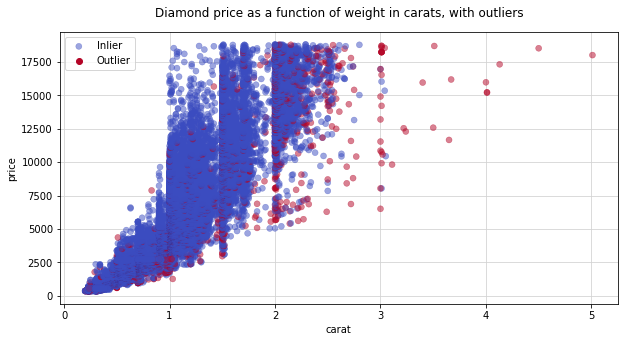

In [24]:
fig, ax = plt.subplots(figsize = (10,5))

sns.scatterplot(
    x=diam_data['carat'],
    y=diam_data['price'],
    ax=ax,
    alpha=0.5,
    edgecolor=None,
    hue=num_outlier_map,
    palette="coolwarm_r"
)

ax.set_title('Diamond price as a function of weight in carats, with outliers', pad=15)

ax.legend(labels=['Inlier', 'Outlier'])

ax.grid(True, color="lightgrey")
ax.set_axisbelow(True)

plt.show()

We can notice that the higher value diamonds get excluded from the analysis when using this approach to remove outliers. While it can be useful for the exploratory analysis, we will try to avoid removing these when looking at modelling.

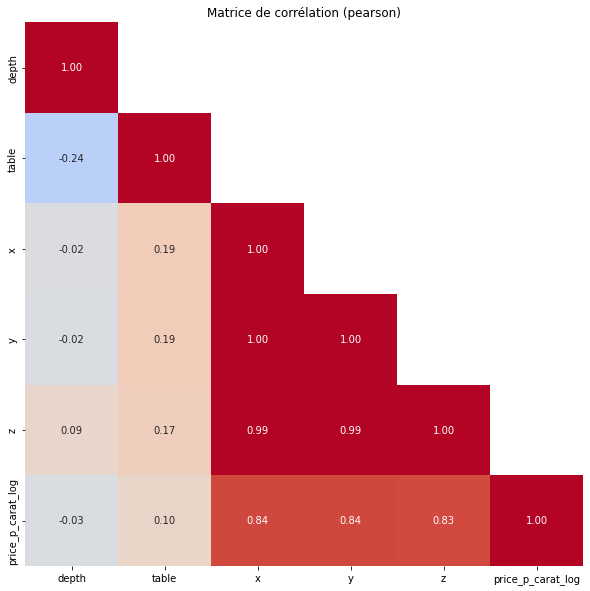

In [25]:
plot_cm(diam_data.loc[num_outlier_map==+1, num_cols])
plt.show()

We can notice a high observed correlation inbetween the x, y, and z dimensions, between these and the weight in carat (log-transformed), and between these 4 and the price per carat, indicating that the size of the diamond impacts its price in a non-linear manner.

Additionnally, we notice a low correlation value between the depth and the dimensions, due to their non-linear formulaic relationship. With these elements in mind, we suggest keeping only a single dimension (out of x, y, z) as variable for our future model, as well as the other variables. We also suggest looking into non-linear models, to better consider possible non-linear relationships.

We can also visualize these relationships through scatter plots.

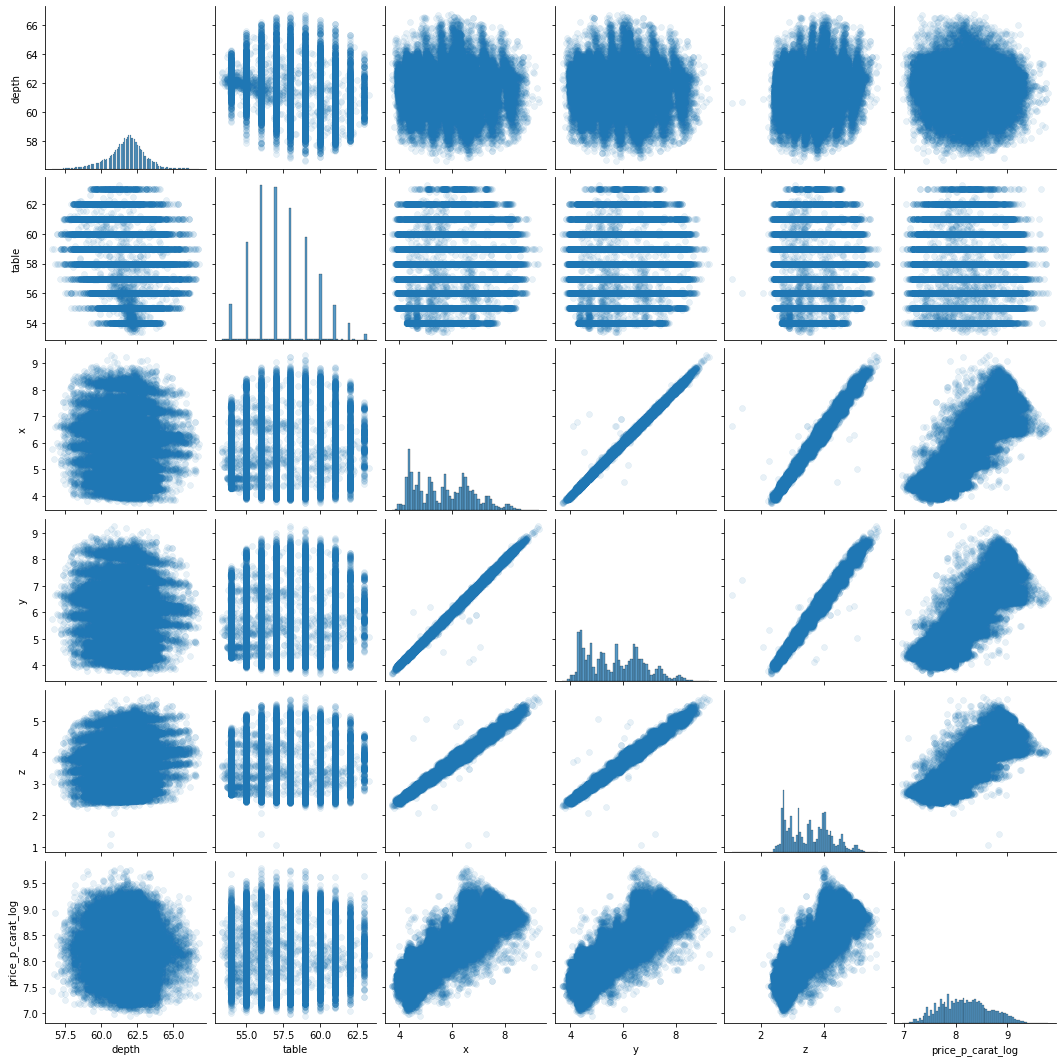

In [26]:
sns.pairplot(
    data=diam_data.loc[num_outlier_map==+1, num_cols],
    plot_kws={'alpha': 0.1, 'edgecolor': None}
)

plt.show()

### 1.5.2. Categorical variables

We can also look into relationships between the price per carat and categorical variables. To this end, we will begin by plotting the combined distribution through a box plot.

In [27]:
#Extract columns for categorical variables (i.e. object or category)
cat_cols = diam_data.columns[np.isin(diam_data.dtypes, ['object', 'category'])]

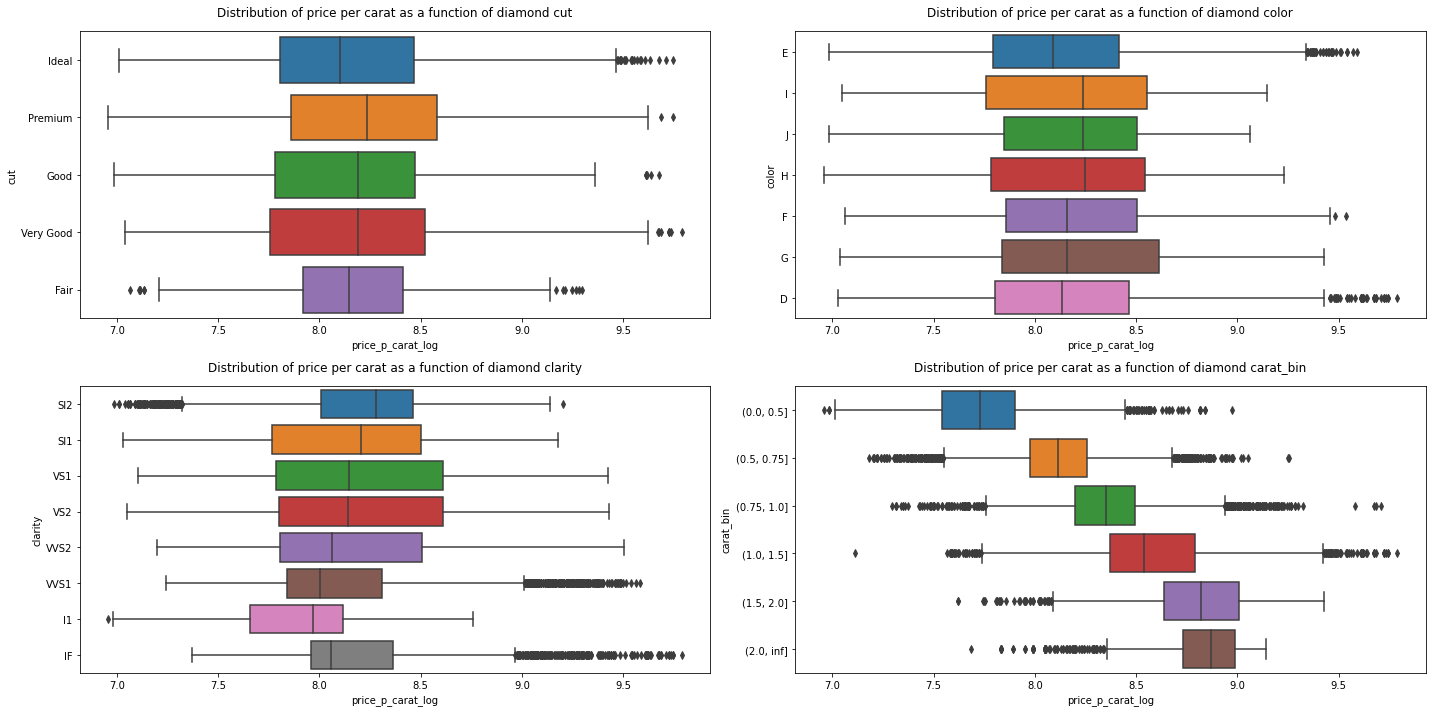

In [28]:
nrow, ncol = get_n_rowcol(cat_cols)
fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*10, nrow*5))

for ax, dim in zip(fig.axes, cat_cols):
    sns.boxplot(
        x=diam_data['price_p_carat_log'],
        y=diam_data[dim],
        ax=ax
    )
    ax.set_title(f"Distribution of price per carat as a function of diamond {dim}", pad=15)
    
fig.set_tight_layout(True)
    
plt.show()

The overall weight of the diamond has a clear impact on pricing, as observed earlier.

We can also notice a possible link between the price and diamond clarity, and likely a limited impact of the other variables. We will explore this further through the analysis of ANOVA, after removal of the outliers, using the Tukey method.

In [29]:
for dim in cat_cols:
    cat_outliers_map = tukey_outliers(
        diam_data[['price_p_carat_log']+[dim]],
        'price_p_carat_log'
    )
    
    anova, p_val_anova, p_val_alexgovern = anova_test(
        diam_data.loc[~cat_outliers_map,['price_p_carat_log']+[dim]],
        dim,
        'price_p_carat_log'
    )
    
    print(f"- {dim}: anova = {anova:.3f}, pval = {p_val_alexgovern:.3f}")

- cut: anova = 0.005, pval = 0.000
- color: anova = 0.003, pval = 0.000
- clarity: anova = 0.009, pval = 0.000
- carat_bin: anova = 0.694, pval = 0.000


While the ANOVA value is small for all except the diamond weight, the p-value of the null hypothesis is close to 0, indicating that the categorical variables seem to have a small but real impact on the price per carat of the diamonds. We will hence include them in our analysis.